In [3]:
from brainlit.map_neurons.diffeo_gen import diffeo_gen_ara
import numpy as np
from scipy.spatial.distance import cosine
from brainlit.map_neurons.map_neurons import (
    Diffeomorphism_Transform,
)
from brainlit.map_neurons.utils import replace_root, ZerothFirstOrderNeuron
import os
from pathlib import Path
from tqdm import tqdm
import os
import pickle
from tqdm import tqdm
from joblib import Parallel, delayed
import ngauge
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import kstest

In [7]:
# INPUTS
sigmas = [40, 80, 160, 320]
sampling = 2.0
ds_factors = [1, 2, 4, 8, 16]
swc_dir = Path(
    "/cis/home/tathey/projects/mouselight/axon_mapping/ds_experiment/mouselight-swcs"
)
swc_dir = Path(
    "/Users/thomasathey/Documents/mimlab/mouselight/axon_mapping/mouselight-swcs/swcs-1"
)

swcs_fnames = os.listdir(swc_dir)
swcs_fnames = [swc_fname for swc_fname in swcs_fnames if "swc" in swc_fname]
swc_paths = [swc_dir / swc_fname for swc_fname in swcs_fnames]

print(
    f"Processing {len(swc_paths)} neurons with a sampling rate of {sampling} and downsampling factor {ds_factors} with max vs of {sigmas} "
)

results_dir = swc_dir / "results"

Processing 20 neurons with a sampling rate of 2.0 and downsampling factor [1, 2, 4, 8, 16] with max vs of [40, 80, 160, 320] 


In [6]:
res_files = os.listdir(results_dir)
res_files = [r for r in res_files if ".swc" in r and "-gt" not in r]

res_sigmas = []
res_samples = []
res_methods = []

res_arbor_dists = []
res_median_tortuosities = []
res_max_tortuosities = []
res_max_segment_lengths = []
res_max_branch_angles = []
res_avg_branch_angles = []
res_max_path_angles = []
res_median_path_angles = []

gt_res_arbor_dists = []
gt_res_median_tortuosities = []
gt_res_max_tortuosities = []
gt_res_max_segment_lengths = []
gt_res_max_branch_angles = []
gt_res_avg_branch_angles = []
gt_res_max_path_angles = []
gt_res_median_path_angles = []

ks_path_angles = []
ks_branch_angles = []
ks_neurites_tortuosities = []
ks_segment_lengths = []

for res_file in tqdm(res_files, desc="reading files"):
    res_path = results_dir / res_file
    neuron = ngauge.Neuron.from_swc(res_path)

    gt_path = str(res_path)[:-5] + "gt.swc"
    neuron_gt = ngauge.Neuron.from_swc(gt_path)

    stem = res_path.stem

    stem_parts = stem.split("-")
    
    res_sigmas.append(int(stem_parts[2]))
    res_samples.append(stem_parts[0])
    res_methods.append(stem_parts[3])

    res_arbor_dists.append(neuron.arbor_dist())
    res_median_tortuosities.append(neuron.median_tortuosity())
    res_max_tortuosities.append(neuron.max_tortuosity())
    res_max_segment_lengths.append(neuron.max_segment_length())
    res_max_branch_angles.append(neuron.max_branch_angle())
    res_avg_branch_angles.append(neuron.avg_branch_angle())
    res_max_path_angles.append(neuron.max_path_angle())
    res_median_path_angles.append(neuron.median_path_angle())


    gt_res_arbor_dists.append(neuron_gt.arbor_dist())
    gt_res_median_tortuosities.append(neuron_gt.median_tortuosity())
    gt_res_max_tortuosities.append(neuron_gt.max_tortuosity())
    gt_res_max_segment_lengths.append(neuron_gt.max_segment_length())
    gt_res_max_branch_angles.append(neuron_gt.max_branch_angle())
    gt_res_avg_branch_angles.append(neuron_gt.avg_branch_angle())
    gt_res_max_path_angles.append(neuron_gt.max_path_angle())
    gt_res_median_path_angles.append(neuron_gt.median_path_angle())

    ks_path_angles.append(kstest(neuron.all_path_angles(), neuron_gt.all_path_angles()).statistic)
    ks_branch_angles.append(kstest(neuron.all_branch_angles(), neuron_gt.all_branch_angles()).statistic)
    ks_neurites_tortuosities.append(kstest(neuron.all_neurites_tortuosities(), neuron_gt.all_neurites_tortuosities()).statistic)
    ks_segment_lengths.append(kstest(neuron.all_segment_lengths(), neuron_gt.all_segment_lengths()).statistic)




reading files: 100%|██████████| 160/160 [24:00<00:00,  9.00s/it]


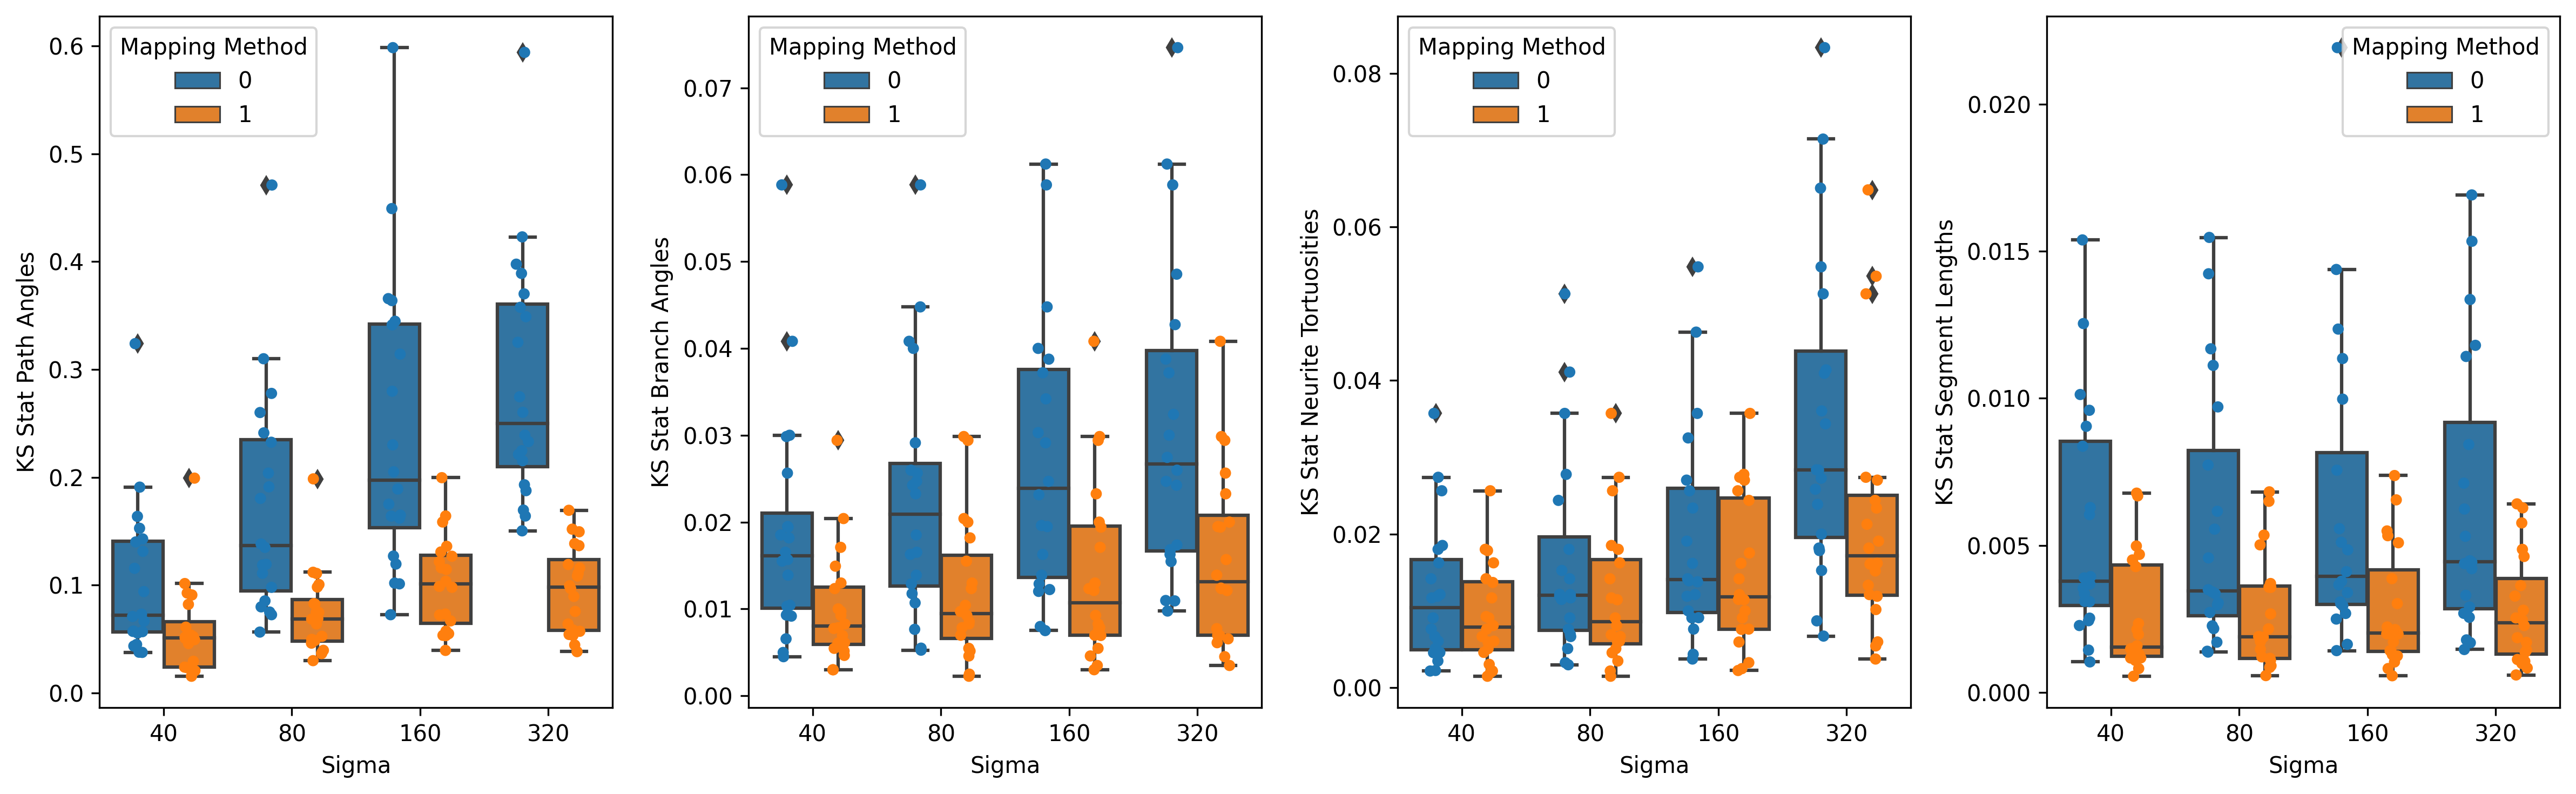

In [9]:
data = {"Sigma": res_sigmas, "Sample": res_samples, "Mapping Method": res_methods, "Arbor Dist": res_arbor_dists, "Median Tortuoisity": res_median_tortuosities, "Max Tortuosity": res_max_tortuosities, 
        "Max Segment Length": res_max_segment_lengths, "Max Branch Angle": res_max_branch_angles, "Avg. Branch Angle": res_avg_branch_angles, "Max Path Angle": res_max_path_angles,
        "Median Path Angle": res_median_path_angles, "GT Arbor Dist": gt_res_arbor_dists, "GT Median Tortuoisity": gt_res_median_tortuosities, "GT Max Tortuosity": gt_res_max_tortuosities, 
        "GT Max Segment Length": gt_res_max_segment_lengths, "GT Max Branch Angle": gt_res_max_branch_angles, "GT Avg. Branch Angle": gt_res_avg_branch_angles, "GT Max Path Angle": gt_res_max_path_angles,
        "GT Median Path Angle": gt_res_median_path_angles, "KS Stat Path Angles": ks_path_angles, "KS Stat Branch Angles": ks_branch_angles, "KS Stat Neurite Tortuosities":ks_neurites_tortuosities,
        "KS Stat Segment Lengths":ks_segment_lengths}

df = pd.DataFrame(data=data)

f, axs = plt.subplots(1, 4, dpi=300)

# for ax, par in zip(axs.flatten()[:8], ["Arbor Dist", "Median Tortuoisity", "Max Tortuosity", "Max Segment Length", "Max Branch Angle", "Avg. Branch Angle", "Max Path Angle", "Median Path Angle"]):
#     sns.scatterplot(data=df[df["Sigma"] == 80], x="GT " + par, y=par, hue="Mapping Method", ax=ax)
#     xmin, xmax = ax.get_xlim()
#     ymin, ymax = ax.get_ylim()
#     min = np.amin([xmin, ymin])
#     max = np.amin([xmax, ymax])
#     sns.lineplot(x=[min, max], y=[min, max], ax=ax)

for ax, par in zip(axs.flatten(), ["KS Stat Path Angles","KS Stat Branch Angles",  "KS Stat Neurite Tortuosities",  "KS Stat Segment Lengths"]):
    sns.stripplot(data=df, x="Sigma", y=par, ax=ax, hue="Mapping Method", dodge=True, edgecolor='gray', legend=None)
    sns.boxplot(data=df, x="Sigma", y=par, ax=ax, hue="Mapping Method")


f.set_figheight(5)
f.set_figwidth(16)
f.tight_layout()